# Digit Recognizer - MNIST Dataset

Based on the video by [Samson Zhang](https://www.youtube.com/watch?v=w8yWXqWQYmU).

## Loading and Splitting Datasets

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/davisnicholomagpantay/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [24]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np
np.random.seed(0)
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

In [25]:

# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = path
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
x_train_img = x_train
x_test_img = x_test
if False:        
    images_2_show = []
    titles_2_show = []
    for i in range(0, 10):
        r = random.randint(1, 60000)
        images_2_show.append(x_train_img[r])
        titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

    for i in range(0, 5):
        r = random.randint(1, 10000)
        images_2_show.append(x_test_img[r])        
        titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

    show_images(images_2_show, titles_2_show)

In [26]:
#
# Turn datasets into numpy arrays, and correct array shapes
#
(x_train, y_train), (x_test, y_test) = (np.array(x_train), np.array(y_train)), (np.array(x_test),np.array(y_test))
x_train = x_train.reshape(x_train.shape[0], -1).T
x_test = x_test.reshape(x_test.shape[0], -1).T

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (784, 60000)
y_train shape: (60000,)
x_test shape: (784, 10000)
y_test shape: (10000,)


## Building the Neural Network

Let ``m`` be the number of training images. Our neural network will have 3 layers:

0. Input layer (784 nodes) - each node represents a pixel on the input image. Denoted by $A^{[0]}$ with dimension ``784 x m``
1. Hidden layer (10 nodes) - each node is a neuron. Denoted by $A^{[1]}$ with dimension ``128 x 1``
2. Output layer (10 nodes) - each node represents the calculated probability for each of the possible 10 digits (0~9). Denoted by $A^{[2]}$ with dimension ``10 x 1``

### Forward Propagation

To go from layer 0 to layer 1, weights $W^{[1]}$ (dim: ``128 x 784``) and biases $b^{[1]}$ (dim: ``128 x 1``) are applied to $A^{[0]}$, then an activation function (e.g., ReLU) is applied:

$$
Z^{[1]} = W^{[1]} \times A^{[0]} + b^{[1]}
$$

$$
A^{[1]} = \text{ReLU}(Z^{[1]})
$$

Note that $\text{ReLU}$ is given by:

$$
\text{ReLU(x)} = \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{if } x \leq 0
\end{cases}
$$

Next, to go from layer 1 to layer 2, another set of weights  $W^{[2]}$ (dim: ``10 x 128``) and biases $b^{[1]}$ (dim: ``10 x 1``) is applied. Afterward, the unactivated values are subjected to another activation function (in this case, softmax):


$$
Z^{[2]} = W^{[2]} \times A^{[1]} + b^{[2]}
$$

$$
A^{[2]} = \text{softmax}(Z^{[2]})
$$

Softmax is used for turning the output layer values into relative probabilities. It is defined as:

$$
\text{softmax}(Z_k) = \frac{e^{Z_k}}{\sum_{j}{e^{Z_k}}}
$$


In [27]:
def init_params(init_const, hidden_neurons=128):
    W1 = np.random.randn(hidden_neurons, 784) * init_const
    b1 = np.full((hidden_neurons,1), 0)
    W2 = np.random.randn(10, hidden_neurons) * init_const
    b2 = np.full((10,1), 0)
    return [W1, b1, W2, b2]

def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    shifted_Z = Z - np.max(Z, axis=0, keepdims=True)
    exps = np.exp(shifted_Z)
    return exps / np.sum(exps, axis=0, keepdims=True)

def forward_propagation(A0, wb, verbose=False):
    W1, b1, W2, b2 = wb[0], wb[1], wb[2], wb[3]
    if verbose:
        print(f"A0: {A0.shape}")
        for i in wb:
            print(f"{i.shape}")

    Z1 = W1.dot(A0) + b1
    if verbose:
        print(f"Z1: {Z1.shape}")

    A1 = ReLU(Z1)
    if verbose:
        print(f"A1: {A1.shape}")

    Z2 = W2.dot(A1) + b2
    if verbose:
        print(f"Z2: {Z2.shape}")

    A2 = softmax(Z2)
    if verbose:
        print(f"A2: {A2.shape}")

    return [A0, Z1, A1, Z2, A2]

### Back Propagation

To update the weights and biases in the network, we find their respective gradients with respect to the one-hot-encoded target labels $Y$ (dim: ``10 x m``).

$$
dZ^{[2]} = A^{[2]} - Y
$$

$$
dW^{[2]} = \frac{1}{m} \times dZ^{[2]}A^{[1]T}
$$

$$
db^{[2]} = \frac{1}{m} \sum{dZ^{[2]}}
$$

$$
dZ^{[1]} = W^{[2]T} \times dZ^{[2]} \cdot g'(Z^{[1]})
$$

$$
dW^{[1]} = \frac{1}{m} dZ^{[1]} \times A^{[0]T}
$$

$$
db^{[1]} = \frac{1}{m} \sum{dz^{[1]}}
$$

($g'$ is simply a check for if $Z^{[1]}$ is positive)

In [28]:
def one_hot_encode(Y, m):
    y_one_hot = np.zeros((10,m))
    for col in range(m):
        target = Y[col]
        y_one_hot[target][col] = 1
    return y_one_hot

def evaluate(A2, Y_orig, m):
    predictions = np.argmax(A2, axis=0)
    correct = (predictions == Y_orig)
    return np.sum(correct)/m * 100

def back_propagation(wb, nn, m, Y_orig, alpha, t=None, verbose=False): #wb : weights and biases, nn: neural net layers
    A0, Z1, A1, Z2, A2 = nn[0], nn[1], nn[2], nn[3], nn[4]
    W1, b1, W2, b2 = wb[0], wb[1], wb[2], wb[3]
    Y = one_hot_encode(Y_orig, m)

    dZ2 = A2 - Y
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * (Z1>0)
    dW1 = (1/m) * dZ1.dot(A0.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    W1 = W1 - alpha*dW1
    b1 = b1 - alpha*db1
    W2 = W2 - alpha*dW2
    b2 = b2 - alpha*db2

    if verbose and (t%5==0):
        cost = (-1/m) * np.sum(Y * np.log(A2 + 1e-8))
        accuracy = evaluate(A2, Y_orig, m)
        print(f"Iter. {t+1} loss: {cost} / accuracy (%): {accuracy}\n")

    return [W1, b1, W2, b2]

## Training Proper

In [29]:
# controls
init_const = 0.01
alpha = 0.001
training_iterations = 50

# ------------------------

A0_train = x_train
m = A0_train.shape[1]
print(f"Initializing:")
print(f"A0_train {A0_train.shape}")

print(f"Starting training: ")
weights_biases = init_params(init_const)
neural_net_layers = [A0_train]
for iter in range(training_iterations):
    neural_net_layers = forward_propagation(neural_net_layers[0], weights_biases)
    weights_biases = back_propagation(weights_biases, neural_net_layers, m, y_train, alpha, t=iter, verbose=True)
    
trained_wb = weights_biases

Initializing:
A0_train (784, 60000)
Starting training: 
Iter. 1 loss: 3.5304591038193576 / accuracy (%): 11.945

Iter. 6 loss: 1.348652290400653 / accuracy (%): 56.223333333333336

Iter. 11 loss: 0.9345705944486182 / accuracy (%): 69.37833333333333

Iter. 16 loss: 0.7716581058264559 / accuracy (%): 75.22833333333332

Iter. 21 loss: 0.6532242863613179 / accuracy (%): 79.905

Iter. 26 loss: 0.5829399212526731 / accuracy (%): 82.47333333333333

Iter. 31 loss: 0.5325385833865075 / accuracy (%): 84.40833333333333

Iter. 36 loss: 0.4978609851406871 / accuracy (%): 85.62166666666667

Iter. 41 loss: 0.47196769222573204 / accuracy (%): 86.34666666666668

Iter. 46 loss: 0.45155508957840795 / accuracy (%): 87.00166666666667



### Testing

Forward propagation successful.
Test set accuracy: 88.03
Prediction samples:


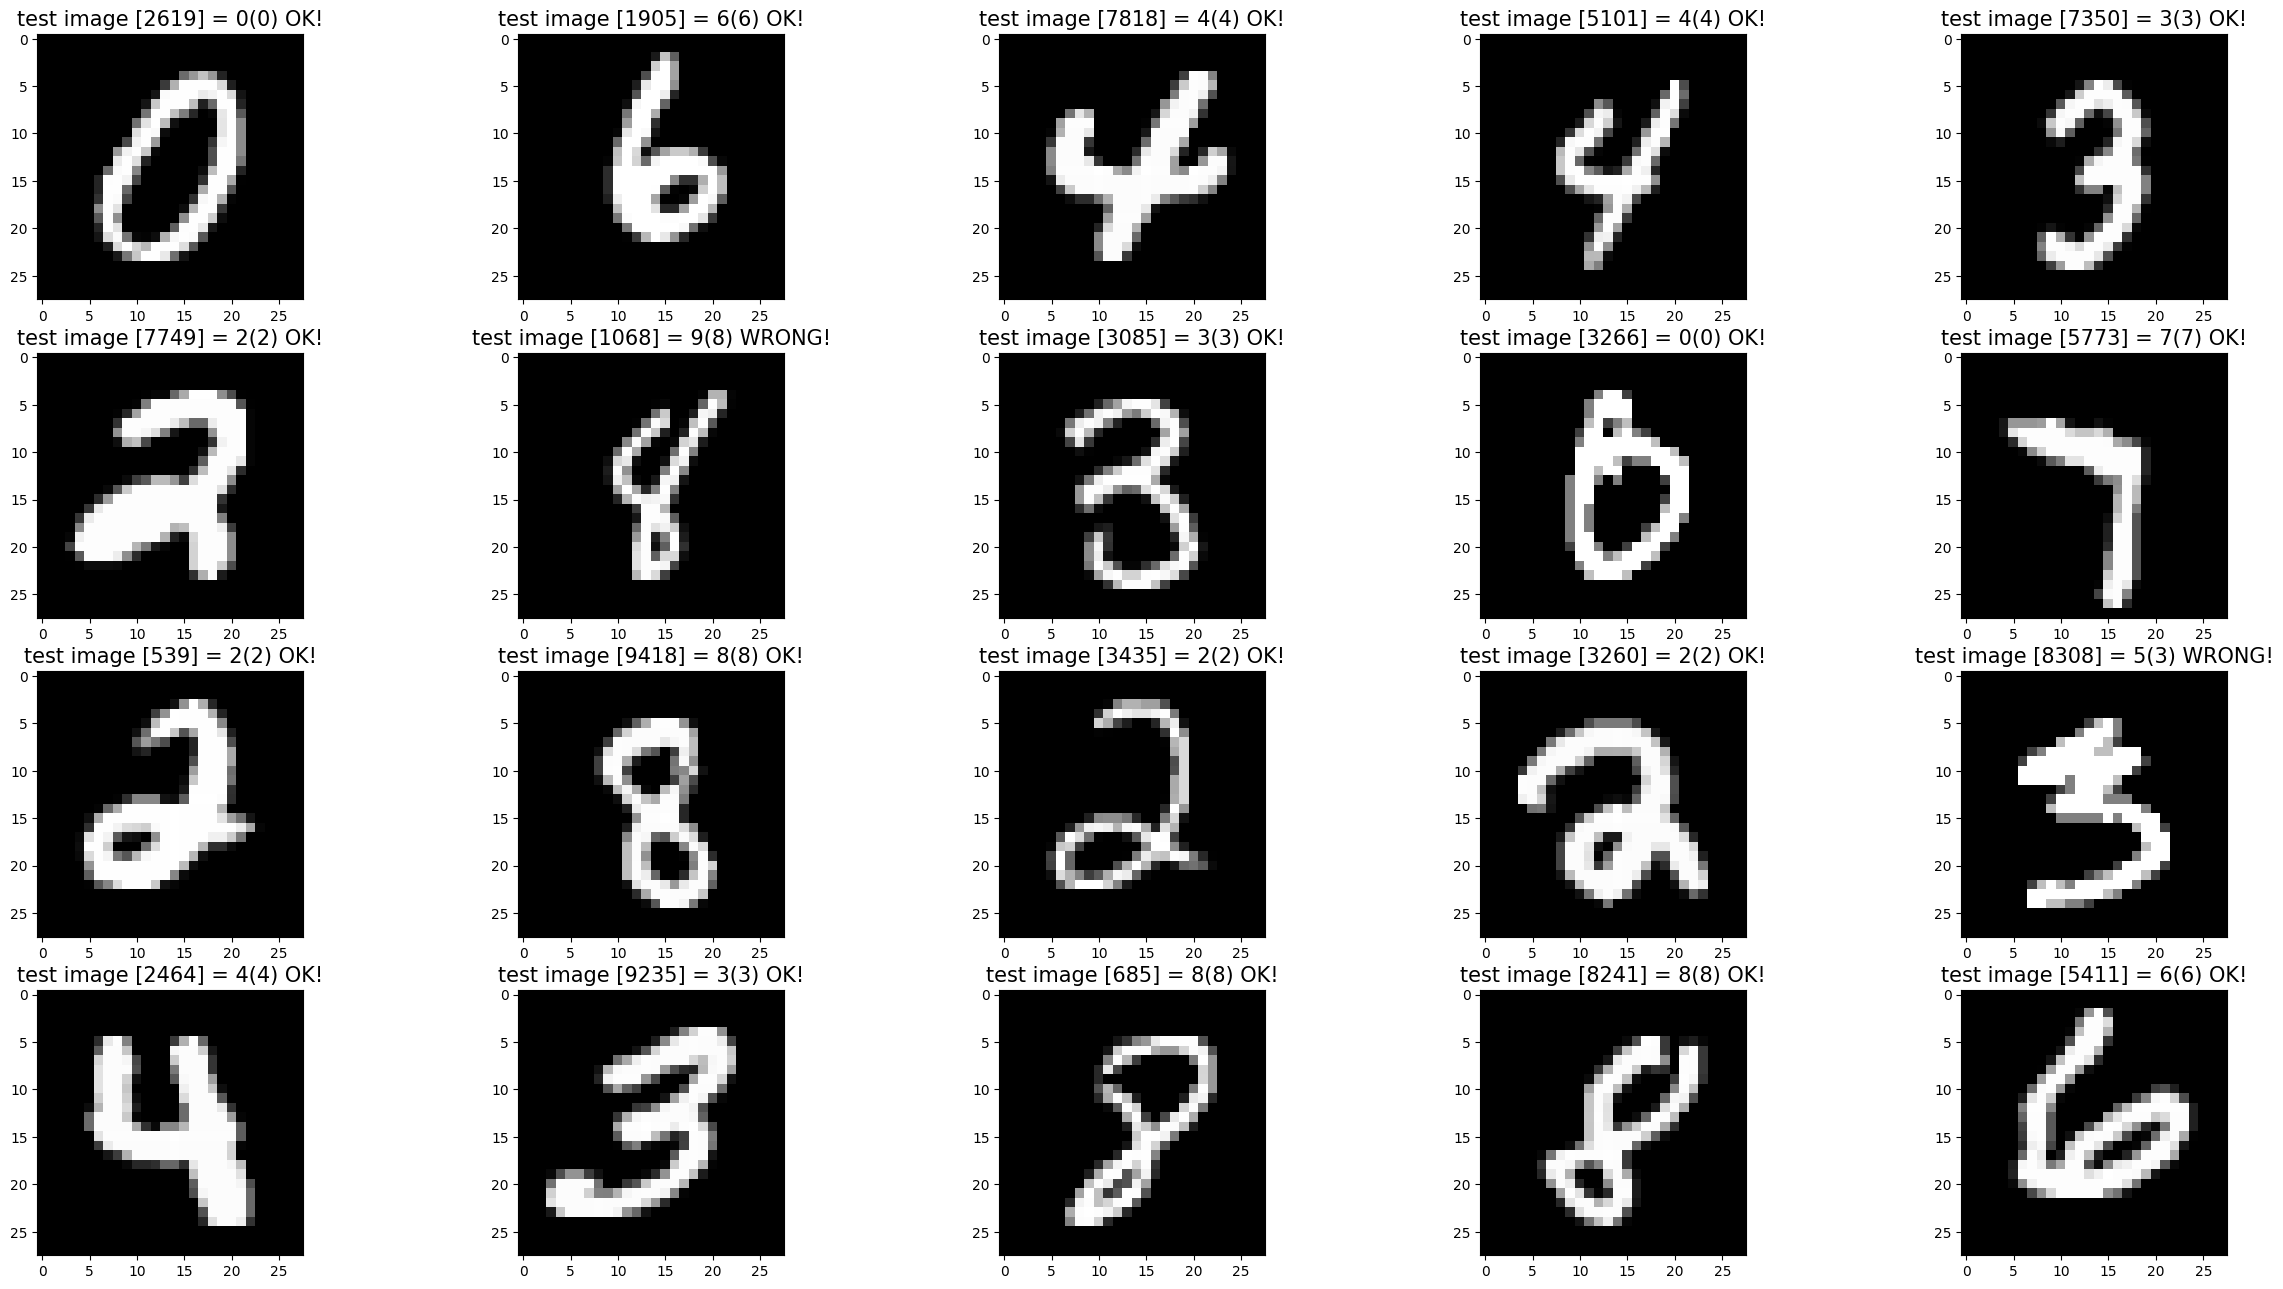

In [34]:
def get_pred(A2, i):
    preds = np.argmax(A2, axis=0)
    return preds[i]

def status(pred, real):
    if pred==real:
        return "OK!"
    return "WRONG!"

A0_test = x_test
m = A0_test.shape[1]
neural_net_actual = [A0_test]

neural_net_actual = forward_propagation(neural_net_actual[0], trained_wb,verbose=False)
print(f"Forward propagation successful.")

final_layer = neural_net_actual[4]
test_accuracy = evaluate(final_layer, y_test, m)
print(f"Test set accuracy: {test_accuracy}")

print(f"Prediction samples:")
if True:        
    images_2_show = []
    titles_2_show = []
    for i in range(0, 20):
        r = random.randint(1, 10000)
        p = get_pred(final_layer, r)
        images_2_show.append(x_test_img[r])        
        titles_2_show.append('test image [' + str(r) + '] = ' + str(p) + "(" + str(y_test[r]) + ")" + " " + status(p,y_test[r]))    

    show_images(images_2_show, titles_2_show)